In [234]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

In [19]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(q)

def show_tables():
    q = ("""
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    """)
    return run_query(q)

In [20]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [21]:
tracks_sold_q = ("""
    SELECT 
        g.name genre,
        SUM(ABS(il.quantity)) tracks_sold,
        (
            SELECT 
                ROUND(CAST(SUM(ABS(il.quantity)) AS float) 
                / CAST(SUM(ABS(quantity)) AS float),5)
            FROM invoice_line
        ) tracks_sold_pct
    FROM track t
    LEFT JOIN invoice_line il ON il.track_id = t.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
    GROUP BY genre
    ORDER BY tracks_sold DESC
""") # Note the triple "
genre_sales = run_query(tracks_sold_q) # Saving the query in a variable, now it's a PD dataframe
genre_sales.dropna(inplace=True) # Removing the rows that contained no sales
genre_sales.set_index("genre", drop=True, inplace=True) # This will allow the labels to plot easier.
genre_sales

,tracks_sold,tracks_sold_pct
genre,,
Rock,561,0.11793
Alternative & Punk,130,0.02733
Metal,124,0.02607
R&B/Soul,53,0.01114
Blues,36,0.00757
Alternative,35,0.00736
Latin,22,0.00462
Pop,22,0.00462
Hip Hop/Rap,20,0.00420


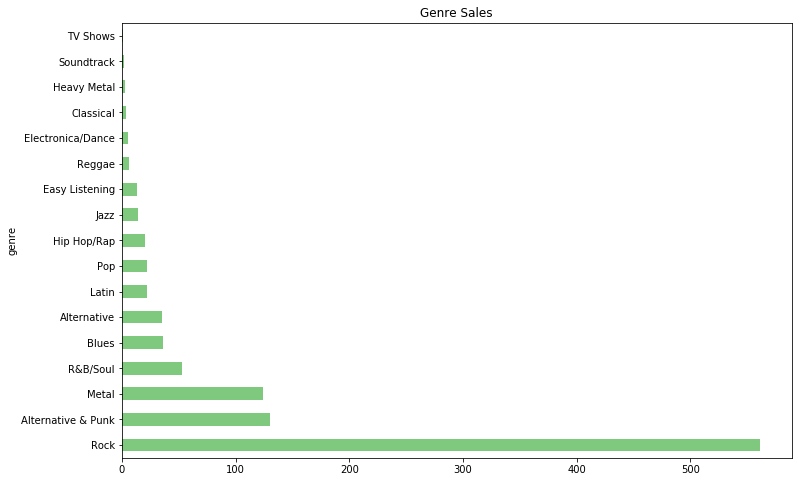

In [22]:
genre_sales["tracks_sold"].plot.barh(figsize=(12,8), label=None, title="Genre Sales", colormap="Accent")
plt.show()

# Genre sales observations

Immediately you will notice that Rock dominates with a little more than half of all the sales. The next are genres which are similar, such as Metal & Alternative/Punk. The next huge gap will be in international music, which contains Latin, R&B/Soul, Blues and Jazz. The next three artists which should enter their music in the store should be in the Rock category. Just for the sheer fact that the numbers show it's what the audience wants.

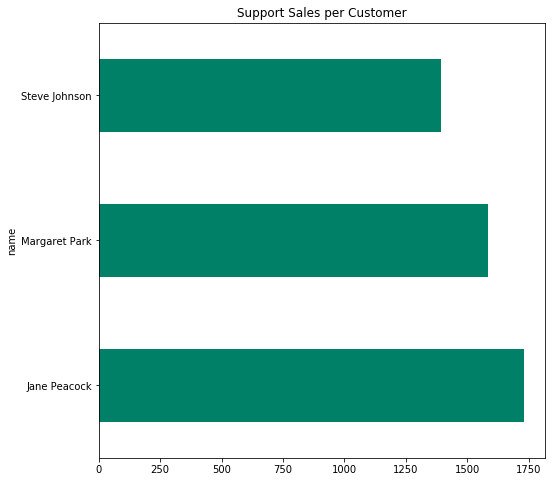

In [23]:
sup_sales = ("""
    SELECT
        e.first_name || " " || e.last_name name,
        e.hire_date hired,
        SUM(i.total) sales_total
    FROM employee e
    LEFT JOIN customer c ON c.support_rep_id = e.employee_id
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    WHERE e.title LIKE "%Agent%"
    GROUP BY name
""")
support_sales = run_query(sup_sales)
support_sales.set_index("name",drop=True,inplace=True)
support_sales.plot.barh(figsize=(8, 8), legend=False, title="Support Sales per Customer", colormap="summer")

# Observations

Jane was not only the longest sales support agent, but had the most sales attached to her support request. The other two were placed 2nd and 3rd properly. I couldn't tell any off signals from birthdays, addresses, managers, or anything

In [117]:
country_stats = ("""
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) avg_order,
        SUM(unit_price) / COUNT(DISTINCT customer_id) avg_cust_sale
    FROM (
            SELECT 
                c.*,
                CASE 
                    WHEN c.country = "Other" THEN 1
                    ELSE 0
                    END AS sort
            FROM country_or_other c
    )
    GROUP BY country
    ORDER BY sort,total_sales DESC
""")
stats = run_query(country_stats)
no_other = stats.drop(9)
stats

,country,customers,total_sales,avg_order,avg_cust_sale
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [265]:
# Second Chart -- Building the table for data
ctv_cols = ["country", "total_sales", "avg_cust_sale"]
cust_total = no_other[ctv_cols].copy()
#cust_total.sort_values("avg_cust_sale", ascending=False, inplace=True)
#cust_total.set_index("country", inplace=True)
#cust_totalt = cust_total.T
cust_total

,country,total_sales,avg_cust_sale
0,USA,1040.49,80.037692
1,Canada,535.59,66.948750
2,Brazil,427.68,85.536000
3,France,389.07,77.814000
4,Germany,334.62,83.655000
5,Czech Republic,273.24,136.620000
6,United Kingdom,245.52,81.840000
7,Portugal,185.13,92.565000
8,India,183.15,91.575000


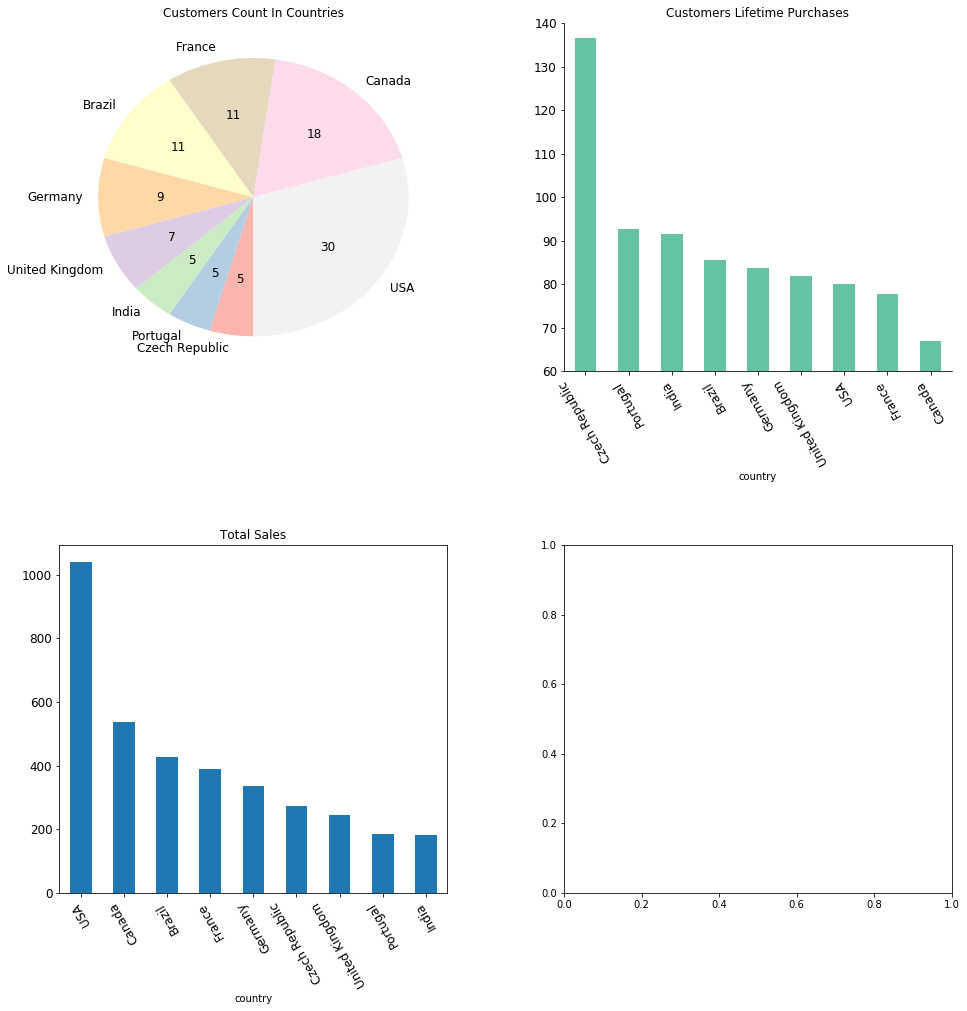

In [286]:
# Creating the board for all charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(2,2, figsize=(8,16))

# First chart -- Building the table for data
cust_count = no_other.loc[:, "country":"customers"]
cust_count.sort_values("customers", inplace=True)
cust_count.set_index("country", inplace=True)

# Plotting the first chart, customer count in countries
ax1.set_title("Customers Count In Countries")
cust_pie = cust_count.plot.pie(
    y="customers", 
    legend=False,
    colormap="Pastel1", 
    autopct='%.f', 
    ax=ax1, 
    label='',
    fontsize=12,
    startangle=-90,
    counterclock=False
)

# Second Chart -- Building the table for data
ctv_cols = ["country", "avg_cust_sale"]
cust_total = no_other[ctv_cols].copy()
cust_total.sort_values("avg_cust_sale", ascending=False, inplace=True)
cust_total.set_index("country", inplace=True)
cust_total_t = cust_total.T

# Plotting #2, customers total purchases over lifetime
ax2.set_title("Customers Lifetime Purchases")
cust_total.plot.bar(
    ax=ax2,
    rot=120,
    colormap="Set2",
    legend=False,
    label='',
    fontsize=12
)
ax2.set_ylim(60, 140)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Plot # 3
ax3.set_title("Total Sales")
ts_cols = ["country", "total_sales"]
total_bar = no_other[ts_cols].copy()
total_bar.sort_values("total_sales", ascending=False, inplace=True)
total_bar.set_index("country", inplace=True)
total_bar.plot.bar(
    ax=ax3,
    rot=120,
    legend=False,
    label='',
    fontsize=12
)

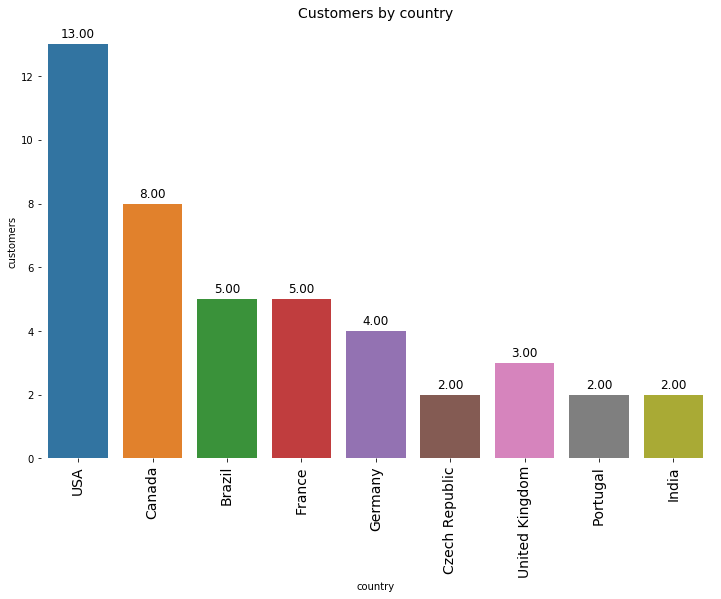

In [11]:
import seaborn as sns # Time to play around with seaborn
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="country", y="customers", data=no_other, label="Total")
ax.set_title("Customers by country", fontsize=14)
ax.set_xticklabels(labels=no_other["country"], rotation=90)
ax.tick_params(axis="x", labelsize=14)
sns.despine(left=True, bottom=True)
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')

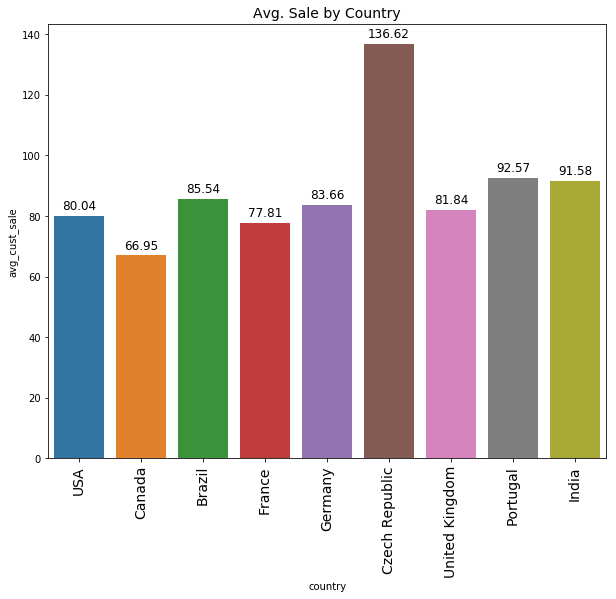

In [12]:
f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x="country", y="avg_cust_sale", data=no_other)
ax.set_xticklabels(labels=no_other["country"], rotation=90)
ax.set_title("Avg. Sale by Country", fontsize=14)
ax.tick_params(axis="x", labelsize=14)
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                 textcoords='offset points')

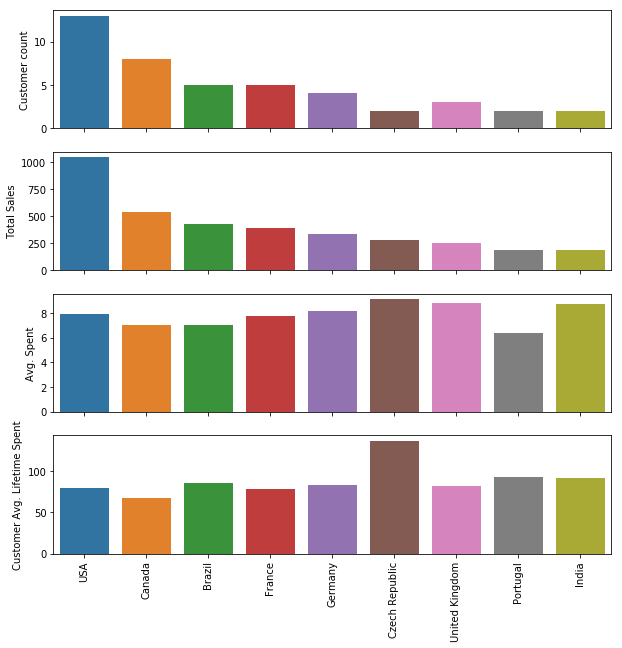

In [13]:
# All data in one 
cols = ["customers", "total_sales", "avg_order", "avg_cust_sale"]
names =["Customer count", "Total Sales", "Avg. Spent", "Customer Avg. Lifetime Spent"]
x = "country"
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10), sharex=True)
ax_count = (ax1, ax2, ax3, ax4)

ax1.tick_params(labelbottom=False)
ax4.set_xticklabels(labels=no_other["country"], rotation=90)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

c = 0
for i in cols:
    g = sns.barplot(x, i, data=no_other, ax=ax_count[c])
    ax_count[c].set_xlabel('')
    ax_count[c].set_ylabel(names[c])
    c = c + 1

In [166]:
album_vs_individual = ("""
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
""") 
run_query(album_vs_individual)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
